# TEXT DETECTION IN IMAGES

There is a common saying, “A picture is worth a thousand words“. Extracting text from images is a very popular task in the operations units of the business as well as in other areas. Here I'm going to take that literally and try to find the words in a picture, to have a look at robust approach for Text Detection In Images Using OpenCV.

## Loading Packages

In [2]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Users\student\AppData\Local\Tesseract-OCR\tesseract.exe"

## Creating argument dictionary with some default values

In [3]:
# Creating argument dictionary for the default arguments needed in the code. 
args = {"image":"C:/Users/student/Desktop/students/ds_45/shahana_vm/project/example_images/peace.jpg" , 
        "data":"C:/Users/student/Desktop/students/ds_45/shahana_vm/project/east_text_detection.pb", 
        "min_confidence":0.5, 
        "width":320, 
        "height":320}


## Image Processing

In [4]:
# Give location of the image to be read
# cv2.imread() method loads an image from the specified file.
img = cv2.imread(args['image'])

In [5]:
# Saving original image and shape
orig_img= img.copy()
o_height, o_width = img.shape[:2]

In [6]:
# Set new height and width to default 320 by using args dictionary
new_height, new_width = args['height'], args['width']

In [7]:
# Calculate the ratio between original image and new image for both height and width
# This ratio will be used to translate bounding box location on the original image
r_height = o_height / float(new_height)
r_width = o_width / float(new_width)

In [8]:
# Resize the original image to new dimensions
img = cv2.resize(img, (new_height, new_width))
height, width = img.shape[:2]

In [9]:
# We need to create a 4-D input blob for feeding the image to the network.
# This is done using the blobFromImage function

blob = cv2.dnn.blobFromImage(img, 1.0 ,(height,width), (123.68, 116.78, 103.94),swapRB = True, crop = False) 

# The first argument is the image itself
# The second argument specifies the scaling of each pixel value. In this case, it is not required. Thus we keep it as 1.
# The default input to the network is 320×320. So, we need to specify this while creating the blob. You can experiment with any other input dimension also.
# We also specify the mean that should be subtracted from each image since this was used while training the model. The mean used is (123.68, 116.78, 103.94).
# The next argument is whether we want to swap the R and B channels. This is required since OpenCV uses BGR format and Tensorflow uses RGB format.
# The last argument is whether we want to crop the image and take the center crop. We specify False in this case

## Loading Pre-trained EAST model and Defining Output Layers

In [10]:
# Load pre-trained EAST model for text detection
net = cv2.dnn.readNet(args["data"])

# cv2.dnn.ReadNet() function load the network into memory.
# It automatically detects configuration and framework based on file name specified.
# In our case, it is a pb file and thus, it will assume that a Tensorflow Network is to be loaded

In [11]:
# We would like to get two outputs from the EAST model. 
# The first layer is our output sigmoid activation which gives us the probability of a region containing text or not.
# The second layer is the output feature map that represents the “geometry” of the image — 
# we’ll be able to use this geometry to derive the bounding box coordinates of the text in the input image
# The following two layer need to pulled from EAST model for achieving this.
layers = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

## Forward pass the Image through EAST model

In [12]:
# We get the output by passing the input image through the network.
# As discussed earlier, the output consists of two parts : scores and geometry.
# Forward pass the image through blob to get the desired output layers.
# net.setInput() - Sets the new value for the layer output blob
net.setInput(blob)
(scores,geometry) = net.forward(layers)

## Function to decode Bounding box from EAST model prediction

In [13]:
# Returns the bounding box and probability score if it is more than minimum confidence
# grab the number of rows and columns from the scores volume.
# Then initialize our set of bounding box rectangles and corresponding confidence scores
def predictions(prob_scores,geo):
    """
    This function will return bounding boxes and associated confidence value
    """
    numRows,numColumns = prob_scores.shape[2:4]
    boxes = []
    cnfdnce_values = []

# We start off by grabbing the dimensions of the scores and then initializing two lists:
# boxes : Stores the bounding box (x, y)-coordinates for text regions.
# cnfdnce_values : Stores the probability associated with each of the bounding boxes in boxes.

    # Loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical data used to derive potential bounding box coordinates that surround text.
        scoresData = prob_scores[0,0,y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]
    
    # In the above, extract our scores and geometry data for the current row, y.
        
        # Loop over the number of columns
        for i in range(0, numColumns):
            # For every row, we begin looping over the columns.
            # We need to filter out weak text detections by ignoring areas that do not have sufficiently high probability
            if scoresData[i] < args["min_confidence"]:
                continue

            # The EAST text detector naturally reduces volume size as the image passes through the network
            # our volume size is actually 4x smaller than our input image so we multiply by four to bring the coordinates back into respect of our original image
            # compute the offset factor
            (offsetX, offsetY) = (i*4.0, y*4.0)

            # Extract the rotation angle from the prediction and compute sine and cosine
            angle = anglesData[i]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # Use the geometry volume to get the height and width of the bounding box
            H = xData0[i] + xData2[i]
            W = xData1[i] + xData3[i]

            # Compute both the starting and ending (x, y)-coordinates for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[i]) + (sin * xData2[i]))
            endY = int(offsetY - (sin * xData1[i]) + (cos * xData2[i]))
            startX = int(endX - W)
            startY = int(endY - H)

            # Add the bounding box coordinates and probability score to our respective lists
            boxes.append((startX, startY, endX, endY))
            cnfdnce_values.append(scoresData[i])

    return(boxes, cnfdnce_values)

## Getting final bounding boxes after Non-Maxima Suppression 

In [14]:
# Find predictions and apply non-maxima suppression to suppress weak, overlapping bounding boxes
(boxes, cnfdnce_values) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs = cnfdnce_values)

## Generating list with bounding box coordinates and recognized text in the boxes

In [15]:
# Initialize the list of results
results = []

# Loop over the bounding boxes to find the coordinate of the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # Scale the coordinates on the respective ratios inorder to reflect bounding box on the original image.
    startX = int(startX * r_width)
    startY = int(startY * r_height)
    endX = int(endX * r_width)
    endY = int(endY * r_height)

    # Extract the region of interest
    r = orig_img[startY:endY , startX:endX]

    # Configuration setting to convert image to string
    configu = ("-l eng --oem 1 --psm 8")

    # This will recognize the text from the image of bounding box
    text = pytesseract.image_to_string(r, config=configu)

    # Append bounding box coordinates and text into list of results
    results.append(((startX, startY, endX, endY),text))

## Display image with bounding box and recognized text

PEACE



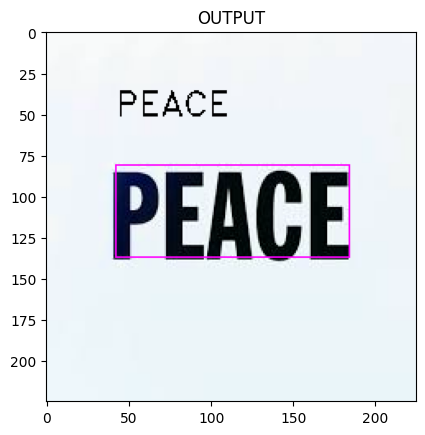

In [16]:
orig_image = orig_img.copy()

#Moving over the results and display the image
for ((startX, startY, endX, endY),text) in results:
    # Display the text detected by tesseract
    print("{}".format(text))

    # Displaying text
    text = "".join([x if ord(x) < 128 else " " for x in text]).strip()
    # ''.join() expression is filtering, removing anything non-ASCII.
    # This handles characters one by one and would still use one space per character replaced.
    # Strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) characters (space is the default leading character to remove)

    cv2.rectangle(orig_image,(startX, startY),(endX, endY),(255,0,255),1)
    cv2.putText(orig_image,text,(startX, startY - 30), cv2.FONT_HERSHEY_DUPLEX, 0.7, (0,0,0), 1)

plt.imshow(orig_image)
plt.title("OUTPUT")
plt.show()